Importing libraries

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import ast
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import norm

sns.set_style('white')

Loading data

In [2]:
with open('match_data.txt') as f:
    data = ast.literal_eval(f.read())

df = pd.DataFrame.from_dict(data)

print(df.head())

        countryA      countryB  scoreA  scoreB  xgA  xgB  possessionA  \
0          Qatar       Ecuador       0       2  0.3  1.2         0.47   
1        England       IR Iran       6       2  2.1  1.4         0.77   
2        Senegal   Netherlands       0       2  0.9  0.7         0.46   
3  United States         Wales       1       1  0.8  1.5         0.58   
4      Argentina  Saudi Arabia       1       2  2.2  0.1         0.69   

   possessionB  passing_accA  passing_accB  shots_on_targetA  \
0         0.53          0.80          0.82              0.00   
1         0.23          0.88          0.65              0.54   
2         0.54          0.78          0.78              0.27   
3         0.42          0.84          0.75              0.17   
4         0.31          0.83          0.66              0.36   

   shots_on_targetB  savesA  savesB  
0              0.40    0.50    0.00  
1              0.29    0.50    0.14  
2              0.30    0.33    1.00  
3              0.33    1

Getting winners, points, and power ranks from matches

In [3]:
countries = set(row.get('countryA') for _, row in df.iterrows())
group_stage_points = {country: 0 for country in countries}
power_ranks = {country: 0 for country in countries}
winner = []

for _, games in df.iterrows():
    countryA = games.get('countryA')
    countryB = games.get('countryB')

    gs_pointA = group_stage_points.get(countryA)
    gs_pointB = group_stage_points.get(countryB)

    #Counting group stage points.
    if games.get('scoreA') > games.get('scoreB'):
        winner.append(countryA)
        group_stage_points[countryA] += 3

    elif games.get('scoreB') > games.get('scoreA'):
        winner.append(countryB)
        group_stage_points[countryB] += 3
        
    else:
        winner.append('Draw')
        group_stage_points[games.get('countryA')] += 1
        group_stage_points[games.get('countryB')] += 1
    
    if gs_pointA == 6 and gs_pointB != 6:
        continue #Match deemed unimportant.
    elif gs_pointB == 6 and gs_pointA != 6:
        continue #Match deemed unimportant.
    
    #Counting power ranks: [goal]^0.5 - [expected goal]^0.5
    power_ranks[countryA] += (games.get('scoreA')**0.5 - games.get('xgA')**0.5)
    power_ranks[countryB] += (games.get('scoreB')**0.5 - games.get('xgB')**0.5)

df['winner'] = winner

Putting Ro16 teams and their FIFA ELO ranks.

In [4]:
ro16 = ['Netherlands', 'United States', 'Argentina', 'Australia', 'France', 'Poland', 'England', 'Senegal', 
        'Japan', 'Croatia', 'Brazil', 'Korea Republic', 'Morocco', 'Spain', 'Portugal', 'Switzerland']
        
power_ranks_ro16 = np.array([power_ranks.get(ro16[i]) for i in range(len(ro16))]).reshape(-1, 1)
power_ranks_normalized = preprocessing.StandardScaler().fit_transform(power_ranks_ro16)

elo_ranks = np.array([2047, 1840, 2118, 1779, 1993, 1827, 1969, 1773, 1841, 1945, 2137, 1801, 1871, 2007, 1993, 1928]).reshape(-1, 1)
elo_ranks_normalized = preprocessing.StandardScaler().fit_transform(elo_ranks)

In [5]:
#Total rank = 50% power rank and 50% FIFA ELO, the result is then used to find the cdf.
total_rank = np.array([norm.cdf((power_ranks_normalized[i] + elo_ranks_normalized[i])/2) for i in range(len(ro16))])

#Total rank is then combined with the countries in a dictionary.
country_rank = {ro16[i]: np.round(total_rank[i], 3) for i in range(len(ro16))}

In [6]:
for i in range(len(total_rank)):
    print(f'{ro16[i]}: {total_rank[i][0]}')

Netherlands: 0.9365249105263311
United States: 0.19417466043849602
Argentina: 0.7999749628305777
Australia: 0.4534033380365353
France: 0.5961169929928856
Poland: 0.0945120255857601
England: 0.663575085654499
Senegal: 0.22848554387626657
Japan: 0.24233262576388243
Croatia: 0.2548723313853137
Brazil: 0.8118104009217266
Korea Republic: 0.16006821091576107
Morocco: 0.4877068013148454
Spain: 0.8579993927869853
Portugal: 0.768386643358964
Switzerland: 0.38102967360127643


Predicting the winner if two teams compete.

In [7]:
def predict_winner(teamA, teamB, form_rank): 
    return random.choices((teamA, teamB), weights=(form_rank.get(teamA), form_rank.get(teamB)))[0] #random.choices is used and their cdf is used for weighting.

Simulation

In [8]:
SIMULATION_AMOUNT = 1000000

wins = {ro16[i]: 0 for i in range(len(ro16))}

for i in range(SIMULATION_AMOUNT):
    ro8 = [predict_winner(ro16[i], ro16[i+1], country_rank) for i in range(0, len(ro16), 2)]
    ro4 = [predict_winner(ro8[i], ro8[i+1], country_rank) for i in range(0, len(ro8), 2)]
    ro2 = [predict_winner(ro4[i], ro4[i+1], country_rank) for i in range(0, len(ro4), 2)]
    winner = predict_winner(ro2[0], ro2[1], country_rank)
    wins[winner] += 1

#Sorting the winners for better viz
wins_sorted = {}
wins_sorted_keys = sorted(wins, key=wins.get)
for key in wins_sorted_keys:
    wins_sorted[key] = wins[key]

Visualization

Text(0.5, 0, 'Percentages won (%)')

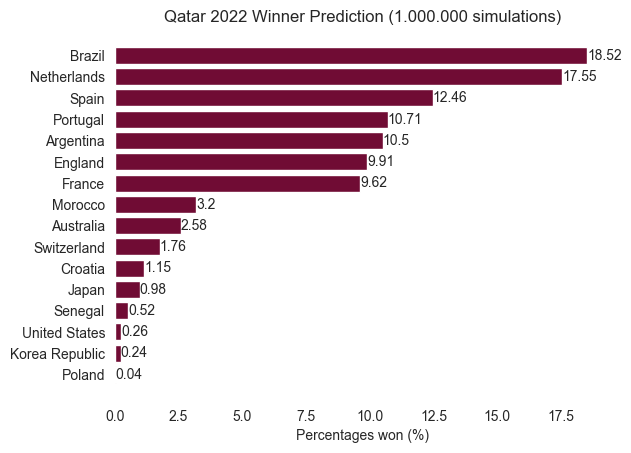

In [9]:
fig, ax = plt.subplots()

bar = ax.barh(wins_sorted_keys, [round(n/10000, 2) for n in list(wins_sorted.values())], color='#700c34')
sns.despine(bottom = True, left = True)
ax.bar_label(bar)
ax.set_title('Qatar 2022 Winner Prediction (1.000.000 simulations)')
ax.set_xlabel('Percentages won (%)')